<a href="https://colab.research.google.com/github/jahnavi-maddhuri/bny-ai-risk-management/blob/for-pres/NeuralNetwork_KBE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
'https://raw.githubusercontent.com/jahnavi-maddhuri/bny-ai-risk-management/refs/heads/for-pres/data/2025_macro_random.csv'


In [14]:
import pandas as pd
import time

from transformers import AutoModel, AutoTokenizer

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [15]:
# load data from github
iv = pd.read_csv('https://raw.githubusercontent.com/jahnavi-maddhuri/\
bny-ai-risk-management/refs/heads/for-pres/data/\
kbe_implied_vol_by_date_Updated.csv')
articles = pd.read_csv('https://raw.githubusercontent.com/jahnavi-maddhuri/\
bny-ai-risk-management/refs/heads/for-pres/data/2025_macro_random.csv')#[['published_dt', 'full_text']]

# change col names/dtypes
iv.rename(columns={'date': 'date_x'}, inplace=True)
iv['pct_change'] = iv['implied_vol'].pct_change()
iv['date_x'] = pd.to_datetime(iv['date_x'], format='%m/%d/%Y')

articles.rename(columns={'published_at': 'date'}, inplace=True)
articles['date'] = pd.to_datetime(pd.to_datetime(articles['date']).dt.date)

# remove articles w/dates not in y
import datetime
articles = articles[articles['date'] >= datetime.datetime(2025, 7, 16)].copy()
iv = iv[iv['date_x'].dt.year==2025].copy()

In [16]:
# create lagged change in iv col
iv = iv.sort_values('date_x')
iv['change_next_day'] = iv['pct_change'].shift(-1)
# iv['change_next_day'] = iv['change_next_day'].abs()

print(f'Price change successfully loaded with columns: {iv.columns}')
print(f'\tPrice change shape: {iv.shape}')
print(f'Articles successfully loaded with columns: {articles.columns}')
print(f'\tArticles shape: {articles.shape}')

Price change successfully loaded with columns: Index(['date_x', 'implied_vol', 'pct_change', 'change_next_day'], dtype='object')
	Price change shape: (117, 4)
Articles successfully loaded with columns: Index(['url_hash', 'title', 'url', 'date', 'ticker', 'topic', 'source'], dtype='object')
	Articles shape: (1779, 7)


In [17]:
articles = articles.sort_values('date')

# Use merge_asof to map to prior available value
df = pd.merge_asof(
    articles,
    iv,
    left_on='date',
    right_on='date_x',
    direction='backward'
)

df.head()

,url_hash,title,url,date,ticker,topic,source,date_x,implied_vol,pct_change,change_next_day
0,3b6129e07d8379e9a5932398d7cefedbb951664b38f787...,Most Gulf markets in red on US inflation conce...,https://news.google.com/rss/articles/CBMitAFBV...,2025-07-16,NaN,"""credit crisis"" OR ""bank failure"" OR ""financia...",gnews,2025-07-16,45.044,1.042534,-0.08263
1,9948d880a27c60bc51f4e2e95139cdc6ab88d1ac2f4b7d...,"Merrill, Morgan Stanley Report Strong Q2 Despi...",https://news.google.com/rss/articles/CBMirAFBV...,2025-07-16,NaN,"""credit crisis"" OR ""bank failure"" OR ""financia...",gnews,2025-07-16,45.044,1.042534,-0.08263
2,9cbfb836937a40fc0dfdc5b9335d575ac50478c05c629d...,4 Value Stocks to Buy as Inflation and Market ...,https://news.google.com/rss/articles/CBMif0FVX...,2025-07-16,NaN,"""credit crisis"" OR ""bank failure"" OR ""financia...",gnews,2025-07-16,45.044,1.042534,-0.08263
3,279f91283cb12eefef74d1a1821961e0c6175c5df4dacd...,Cash acting as an emotional safety net during ...,https://news.google.com/rss/articles/CBMimAFBV...,2025-07-16,NaN,"""credit crisis"" OR ""bank failure"" OR ""financia...",gnews,2025-07-16,45.044,1.042534,-0.08263
4,e19cb59f499e841d25a851760d3a2b684a8e166207d7d6...,3 American Century Mutual Funds to Navigate Ma...,https://news.google.com/rss/articles/CBMigwFBV...,2025-07-16,NaN,"""credit crisis"" OR ""bank failure"" OR ""financia...",gnews,2025-07-16,45.044,1.042534,-0.08263


In [18]:
# df['change_next_day']=df['change_next_day']*100

In [19]:
df = df[df['change_next_day'].notna()].copy()

In [ ]:
tokenizer = AutoTokenizer.from_pretrained('ProsusAI/finbert')

def prepare_data(df, max_articles=20, max_length=512):
    """
    df: DataFrame with columns ['date_x', 'full_text', 'change_next_day']
    """
    # Group articles by date
    grouped = df.groupby('date_x')

    X_tokens = []
    X_masks = []
    y = []

    for date, group in grouped:
        articles_text = group['title'].tolist()[:max_articles]

        # Pad if fewer than max_articles
        while len(articles_text) < max_articles:
            articles_text.append("")  # Empty articles will be masked

        # Tokenize all articles for this day
        encoded = tokenizer(
            articles_text,
            padding='max_length',
            truncation=True,
            max_length=max_length,
            return_tensors='pt'
        )

        X_tokens.append(encoded['input_ids'])
        X_masks.append(encoded['attention_mask'])
        y.append(group['change_next_day'].iloc[0])

    return torch.stack(X_tokens), torch.stack(X_masks), torch.tensor(y)

In [20]:
X_tokens, X_masks, y = prepare_data(df)

## Define NN

In [9]:
class Model(nn.Module):
    def __init__(self, hidden_dim=768, num_heads=8, dropout=0.1):
        super().__init__()

        # 1. FinBERT for embedding articles
        self.finbert = AutoModel.from_pretrained('ProsusAI/finbert')

        # Freeze FinBERT if you want (or fine-tune it)
        for param in self.finbert.parameters():
            param.requires_grad = False

        # 2. Self-attention to weigh importance of different articles
        self.attention = nn.MultiheadAttention(
            embed_dim=hidden_dim,
            num_heads=num_heads,
            dropout=dropout,
            batch_first=True
        )

        # 3. Layer normalization
        self.layer_norm = nn.LayerNorm(hidden_dim)

        # 4. Aggregation layer (combines multiple article embeddings)
        self.aggregation = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(dropout)
        )

        # 5. Final prediction layers
        # FIXED: Input size should be hidden_dim // 2 = 384, not 256
        self.predictor = nn.Sequential(
            nn.Linear(hidden_dim // 2, 128),  # Changed from 256 to hidden_dim // 2
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(64, 1)  # Predict price change
        )

    def forward(self, article_tokens, attention_masks, additional_features=None):
        """
        article_tokens: [batch_size, num_articles, seq_len]
        attention_masks: [batch_size, num_articles, seq_len]
        additional_features: [batch_size, num_features] - optional (not used in this version)
        """
        batch_size, num_articles, seq_len = article_tokens.shape

        # 1. Embed each article with FinBERT
        article_tokens_flat = article_tokens.view(-1, seq_len)
        attention_masks_flat = attention_masks.view(-1, seq_len)

        with torch.no_grad():
            outputs = self.finbert(
                input_ids=article_tokens_flat,
                attention_mask=attention_masks_flat
            )

        # Use [CLS] token embedding for each article
        article_embeddings = outputs.last_hidden_state[:, 0, :]
        article_embeddings = article_embeddings.view(batch_size, num_articles, -1)

        # 2. Apply self-attention across articles
        attended_embeddings, attention_weights = self.attention(
            article_embeddings,
            article_embeddings,
            article_embeddings
        )

        # 3. Layer norm and residual connection
        attended_embeddings = self.layer_norm(attended_embeddings + article_embeddings)

        # 4. Aggregate articles (mean pooling)
        aggregated = torch.mean(attended_embeddings, dim=1)  # [batch_size, hidden_dim]

        # 5. Pass through aggregation layer
        aggregated = self.aggregation(aggregated)  # [batch_size, hidden_dim//2] = [batch_size, 384]

        # 6. Final prediction
        price_change = self.predictor(aggregated)  # Now expects [batch_size, 384]

        return price_change, attention_weights

## Train NN

In [21]:
# Split Train/Test 80/20 temporal split
TRAIN_DAYS = round(0.8*len(X_tokens))
TEST_DAYS = len(X_tokens)-TRAIN_DAYS

X_train_tokens = X_tokens[:TRAIN_DAYS]
X_train_masks = X_masks[:TRAIN_DAYS]
y_train = y[:TRAIN_DAYS]

X_test_tokens = X_tokens[TRAIN_DAYS:]
X_test_masks = X_masks[TRAIN_DAYS:]
y_test = y[TRAIN_DAYS:]

print(f"Training on {len(y_train)} days")
print(f"Testing on {len(y_test)} days")

Training on 93 days
Testing on 23 days


In [22]:
# Create datasets
train_dataset = TensorDataset(X_train_tokens, X_train_masks, y_train)
test_dataset = TensorDataset(X_test_tokens, X_test_masks, y_test)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

# Initialize model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Model()
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.MSELoss()

# Early stopping configuration for 220 days
best_test_loss = float('inf')
patience = 10  # Increased from 5 (larger dataset = more patience)
patience_counter = 0
best_model_state = None

# Also increase max epochs since you have more data
for epoch in range(200):  # Increased from 100
    start_time = time.time()

    # Training
    model.train()
    train_loss = 0
    for tokens, masks, targets in train_loader:
        tokens, masks, targets = tokens.to(device), masks.to(device), targets.to(device)
        optimizer.zero_grad()
        predictions, _ = model(tokens, masks)
        loss = criterion(predictions.squeeze(), targets.float())
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    # Validation
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for tokens, masks, targets in test_loader:
            tokens, masks, targets = tokens.to(device), masks.to(device), targets.to(device)
            predictions, _ = model(tokens, masks)
            loss = criterion(predictions.squeeze(), targets.float())
            test_loss += loss.item()

    avg_train_loss = train_loss / len(train_loader)
    avg_test_loss = test_loss / len(test_loader)
    epoch_time = time.time() - start_time

    print(f"Epoch {epoch+1} - Time: {epoch_time:.2f}s")
    print(f"  Train Loss: {avg_train_loss:.4f}")
    print(f"  Test Loss: {avg_test_loss:.4f}")

    # Check for overfitting
    if avg_train_loss < avg_test_loss * 0.5:
        print(f"  ⚠️ Overfitting detected")

    # Early stopping logic
    if avg_test_loss < best_test_loss:
        best_test_loss = avg_test_loss
        patience_counter = 0
        best_model_state = model.state_dict().copy()
        print(f"  ✓ New best test loss!")
    else:
        patience_counter += 1
        print(f"  No improvement ({patience_counter}/{patience})")

    if patience_counter >= patience:
        print(f"\nEarly stopping at epoch {epoch+1}")
        break

# Load best model
if best_model_state is not None:
    model.load_state_dict(best_model_state)
    print(f"\nLoaded best model with test loss: {best_test_loss:.4f}")

Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertModel LOAD REPORT from: ProsusAI/finbert
Key                          | Status     |  | 
-----------------------------+------------+--+-
bert.embeddings.position_ids | UNEXPECTED |  | 
classifier.weight            | UNEXPECTED |  | 
classifier.bias              | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Epoch 1 - Time: 68.50s
  Train Loss: 0.1491
  Test Loss: 0.0544
  ✓ New best test loss!
Epoch 2 - Time: 67.75s
  Train Loss: 0.1413
  Test Loss: 0.0541
  ✓ New best test loss!
Epoch 3 - Time: 67.45s
  Train Loss: 0.1406
  Test Loss: 0.0543
  No improvement (1/10)
Epoch 4 - Time: 67.75s
  Train Loss: 0.1461
  Test Loss: 0.0528
  ✓ New best test loss!
Epoch 5 - Time: 67.64s
  Train Loss: 0.1386
  Test Loss: 0.0541
  No improvement (1/10)
Epoch 6 - Time: 67.79s
  Train Loss: 0.1382
  Test Loss: 0.0557
  No improvement (2/10)
Epoch 7 - Time: 67.78s
  Train Loss: 0.1427
  Test Loss: 0.0559
  No improvement (3/10)
Epoch 8 - Time: 67.87s
  Train Loss: 0.1390
  Test Loss: 0.0567
  No improvement (4/10)
Epoch 9 - Time: 67.70s
  Train Loss: 0.1423
  Test Loss: 0.0569
  No improvement (5/10)
Epoch 10 - Time: 67.51s
  Train Loss: 0.1353
  Test Loss: 0.0606
  No improvement (6/10)
Epoch 11 - Time: 67.70s
  Train Loss: 0.1275
  Test Loss: 0.0631
  No improvement (7/10)
Epoch 12 - Time: 67.86s
  Trai

# Analyze model performance

In [23]:
# Set model to evaluation mode
model.eval()

# Get predictions on test set
predictions = []
actuals = []

with torch.no_grad():
    for tokens, masks, targets in test_loader:
        tokens = tokens.to(device)
        masks = masks.to(device)

        preds, _ = model(tokens, masks)
        predictions.extend(preds.squeeze().cpu().numpy())
        actuals.extend(targets.numpy())

# Convert to numpy arrays
predictions = np.array(predictions)
actuals = np.array(actuals)

# # Display predicted vs actual
# print("Predicted vs Actual Price Changes:")
# print("=" * 50)
# print(f"{'Day':<6} {'Actual':<12} {'Predicted':<12} {'Error':<12}")
# print("=" * 50)
# for i, (actual, pred) in enumerate(zip(actuals, predictions)):
#     error = actual - pred
#     print(f"{i+1:<6} {actual:>11.2f}% {pred:>11.2f}% {error:>11.2f}%")
# print("=" * 50)

MODEL EVALUATION METRICS
Mean Squared Error (MSE):     0.0783
Root Mean Squared Error (RMSE): 0.2798
Mean Absolute Error (MAE):    0.2135
R² Score:                     -0.5439
Direction Accuracy:           60.87%


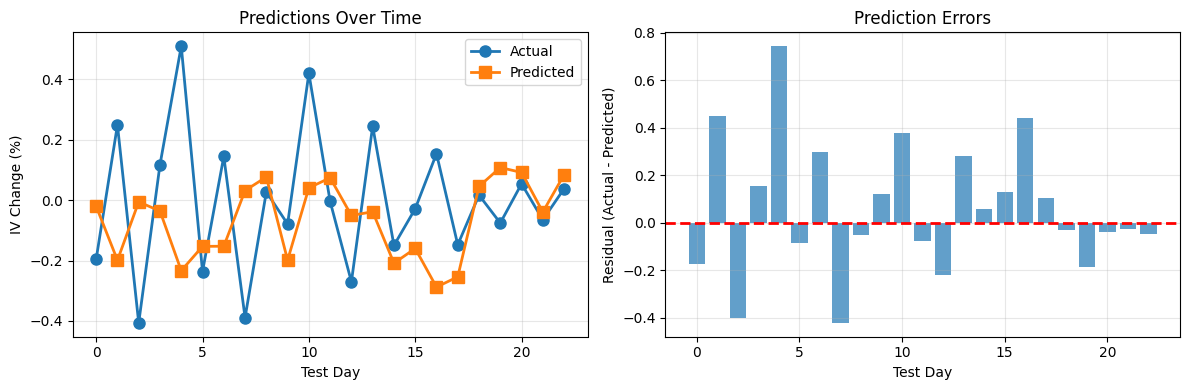

In [24]:
# Calculate metrics
mse = mean_squared_error(actuals, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(actuals, predictions)
r2 = r2_score(actuals, predictions)

# Direction accuracy (did we predict the right direction?)
pred_direction = np.sign(predictions)
actual_direction = np.sign(actuals)
direction_accuracy = np.mean(pred_direction == actual_direction) * 100

print("=" * 50)
print("MODEL EVALUATION METRICS")
print("=" * 50)
print(f"Mean Squared Error (MSE):     {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE):    {mae:.4f}")
print(f"R² Score:                     {r2:.4f}")
print(f"Direction Accuracy:           {direction_accuracy:.2f}%")
print("=" * 50)

plt.figure(figsize=(12, 4))
# Visualization 2: Time Series Plot
# plt.subplot(1, 3, 2)
plt.subplot(1, 2, 1)
days = np.arange(len(actuals))
plt.plot(days, actuals, 'o-', label='Actual', linewidth=2, markersize=8)
plt.plot(days, predictions, 's-', label='Predicted', linewidth=2, markersize=8)
plt.xlabel('Test Day')
plt.ylabel('IV Change (%)')
plt.title('Predictions Over Time')
plt.legend()
plt.grid(True, alpha=0.3)

# Visualization 3: Residuals (Prediction Errors)
# plt.subplot(1, 3, 3)
plt.subplot(1, 2, 2)
residuals = actuals - predictions
plt.bar(days, residuals, alpha=0.7)
plt.axhline(y=0, color='r', linestyle='--', linewidth=2)
plt.xlabel('Test Day')
plt.ylabel('Residual (Actual - Predicted)')
plt.title('Prediction Errors')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()